In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [3]:
def parse_structure_files(data_path, encoding):
    structure_files = {}
    p = Path(data_path)
    for struct_dir in p.iterdir():
        if not struct_dir.is_dir():
            continue
        for file in struct_dir.glob(f"*{encoding}*.csv"):
            structure_name = os.path.basename(struct_dir)
            structure_files[structure_name] = file
            
    return structure_files

In [4]:
encoding = "column_mass"
structure_files = parse_structure_files(DATA_DIR, encoding)

In [5]:
df = pd.concat([pd.read_csv(filepath, index_col=0).assign(structure=struct_name) for struct_name, filepath in structure_files.items()], ignore_index=True)
df = df[["structure"] + df.columns.tolist()[:-1]]

In [6]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', "n_iterations", "delta_E", "fermi", "total_energy"]
cols_independent = ['time']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [7]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [8]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,accuracy,Lant,PTC1,PTC2,PTC3,PTC4,PTC5,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,43889.000000,43889.000000,43889.000000,4.388900e+04,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,...,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.0
mean,245.122468,5.831985,58.435485,3.207548e-10,0.136205,0.041630,0.067004,0.028724,0.025873,0.043036,...,0.068255,0.064416,0.043189,0.037087,0.050327,0.056582,0.100805,0.058153,0.031528,0.0
std,89.287796,2.836652,24.078485,2.831580e-10,0.284523,0.170954,0.212410,0.120764,0.116564,0.172042,...,0.214823,0.207283,0.164395,0.151223,0.172163,0.172108,0.218076,0.156170,0.144224,0.0
min,100.000000,2.000000,20.000000,1.600000e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,40.000000,7.500000e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,60.000000,2.300000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,5.300000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068581,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,1.000000e-09,1.000000,1.000000,1.000000,0.741626,0.841555,1.000000,...,1.000000,1.000000,1.000000,0.803422,0.967155,1.000000,0.918451,0.637235,0.833172,0.0


# Train-Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [10]:
linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [11]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [12]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [13]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [14]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [15]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [16]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:1.3173E+10	test:1.1532E+10
MAE:	train:5.3457E+04	test:5.2248E+04
MAPE:	train:1.6244E+01	test:1.6367E+01
Done!

Evaluating Random Forest...
MSE:	train:1.7158E+08	test:1.0379E+09
MAE:	train:3.2016E+03	test:7.5543E+03
MAPE:	train:5.2371E-02	test:1.2266E-01
Done!

Evaluating XGBoost...
MSE:	train:3.8498E+07	test:1.2883E+09
MAE:	train:2.9201E+03	test:8.7156E+03
MAPE:	train:3.1708E-01	test:5.9347E-01
Done!



# Visualization

Text(0.5, 0, 'ecutwfc')

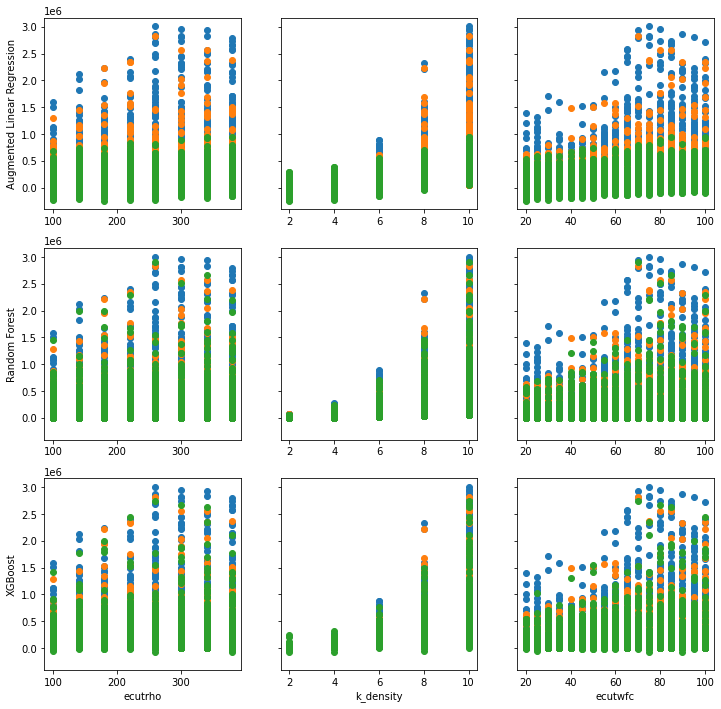

In [17]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

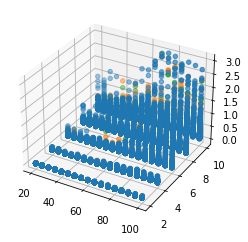

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))